In [225]:
import numpy as np
import pandas as pd
import re

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text
from nltk.util import ngrams

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division
from difflib import SequenceMatcher as seq_matcher

import seaborn as sns

** Evaluation Metric: RMSE **

```
Important points:

1. in is different from in. ( inches )
2. ft. should be converted to feet
3. cu. should be converted to cubic
4. &amp; should be converted to and
5. x acts as a separator between different dimensions e.g. ( 3 x 4 ), ( 1 x 2 x 3) etc.
6. BTU should be converted to British Thermal Unit
7. OTR should be converted to over the range
8. oz. should be converted to ounces
9. sq. should be converted to square
10. lb. should be converted to pounds
11. / should be converted to by
12. gal. should be converted to gallon
13. mm should be converted to millimeter
```

In [219]:
# load train and test data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

### We have search term and product title and we need to predict whether the product shown is relevant or not with  1 being non-relevant to 3 being with highly relevant 

```
Methodology:

1. Explore data set
2. Develop notion of relevance
3. Text preprocessing
4. Tokenization
5. Stemming
6. Machine Learning
```

` Note that test set contains both seen and unseen search terms `

** Data preprocessing **

In [222]:
pattern = re.compile(r'\b(' + r'|'.join(text.ENGLISH_STOP_WORDS) + r')\b\s*')

In [223]:
def filter_characters(char):
    return char == '\n' or 32 <= ord(char) <= 126

def sanitize(s):
    s = s.replace('ft.', 'feet')
    s = s.replace('cu.', 'cubic')
    s = s.replace('mm', 'milimeters')
    s = s.replace('oz.', 'ounces')
    s = s.replace('btu', 'british thermal unit')
    s = s.replace('otr', 'over the range')
    s = s.replace('lb.', 'pounds')
    s = s.replace('in.', 'inches')
    s = s.replace('&amp;', 'and')
    s = s.replace('sq.', 'square')
    s = s.replace('gal.', 'gallon')
    
    return s

def preprocess(s):
    s = filter(filter_characters, s)
    s = s.lower()
    s = sanitize(s)
    
    return pattern.sub('', s)

In [224]:
train.loc[:, 'product_title'] = train.product_title.map(preprocess)
train.loc[:, 'search_term'] = train.search_term.map(preprocess)

** Some utility function for measuring relevance **

In [229]:
def create_set(x):
    x = x.lower() # lowecase string
    x = x.split(' ') # split on empty space will work on clever ways to do this later
    return set(x)

def Dice(row):
    product_title = row['product_title']
    search_term = row['search_term']
    
    product_title = create_set(product_title)
    search_term = create_set(search_term)

    return (2 * len(product_title & search_term)) / (len(product_title) + len(search_term))

def Jaccard(row):
    product_title = row['product_title']
    search_term = row['search_term']
    
    product_title = create_set(product_title)
    search_term = create_set(search_term)
    
    return len(product_title & search_term) / len(product_title | search_term)

def Overlap(row):
    product_title = row['product_title']
    search_term = row['search_term']
    
    product_title = create_set(product_title)
    search_term = create_set(search_term)
    
    return len(product_title & search_term) / min(len(product_title), len(search_term))

In [230]:
train.loc[:, 'dice_relevance'] = train.apply(Dice, axis=1)

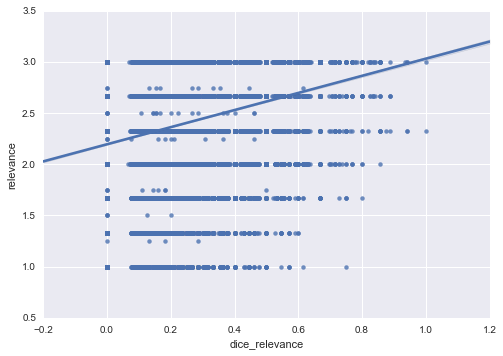

In [9]:
# is there any correlation between releavance and dice_relevance
sns.regplot(x = 'dice_relevance', y = 'relevance', data=train);

In [231]:
train.loc[:, 'jaccard_relevance'] = train.apply(Jaccard, axis=1)

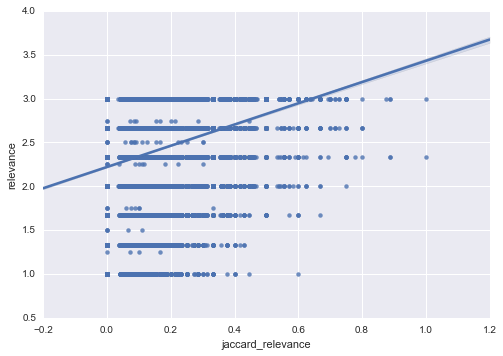

In [13]:
# is there any correlation between releavance and jaccard_relevance
sns.regplot(x = 'jaccard_relevance', y = 'relevance', data=train);

In [232]:
train.loc[:, 'overlap'] = train.apply(Overlap, axis=1)

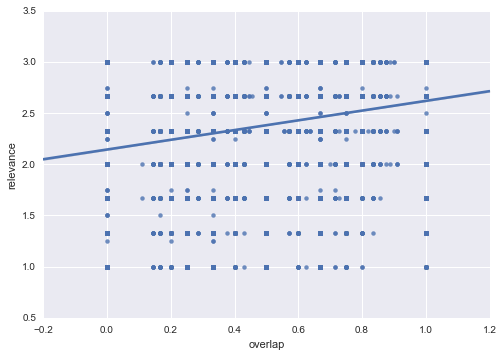

In [15]:
# is there any correlation between releavance and overlap
sns.regplot(x = 'overlap', y = 'relevance', data=train);

In [127]:
def generate_ngrams(sentence, ngram_range=3):
    possible_combinations = []
    for n in range(1, ngram_range + 1):
        ngram_tuples = ngrams(sentence.split(), n)
        for gram in ngram_tuples:
            term = ' '.join(gram)
            possible_combinations.append(term)
    return possible_combinations

def average_dice(row):
    search_term = row['search_term']
    product_title = row['product_title']
    
    product_title = product_title.lower()
    
    search_term_combinations = generate_ngrams(search_term, ngram_range=6) # generate possible combinations
    dice_scores = 0 # keep track of dice score
    product_title_count = len(set(product_title.split(' ')))
    
    for term in search_term_combinations:
        term = term.lower()
        term_words = term.split(' ')
        intersection_count = np.array([1 if w in product_title else 0 for w in term_words]).sum(axis=0)
        dice_scores += ((2 * intersection_count) / (product_title_count + len(set(term_words))))
    
    return dice_scores / 6.

def average_jaccard(row):
    search_term = row['search_term']
    product_title = row['product_title']
    
    product_title = product_title.lower()
    
    search_term_combinations = generate_ngrams(search_term, ngram_range=6) # generate possible combinations
    jaccard_score = 0 # keep track of jaccard score
    product_title_set = set(product_title.split(' '))
    
    for term in search_term_combinations:
        term = term.lower()
        term_words = term.split(' ')
        intersection_count = np.array([1 if w in product_title else 0 for w in term_words]).sum(axis=0)
        jaccard_score += (intersection_count / len(product_title_set |  set(term_words)))
    
    return jaccard_score / 6.


In [125]:
train.loc[:, 'average_dice_score'] = train.apply(average_dice, axis=1)

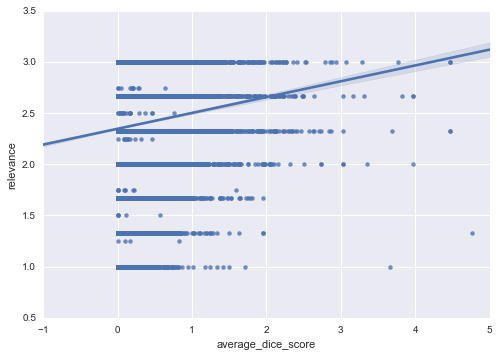

In [126]:
sns.regplot(x = 'average_dice_score', y = 'relevance', data=train);

In [130]:
train.loc[:, 'average_jaccard_score'] = train.apply(average_jaccard, axis=1)

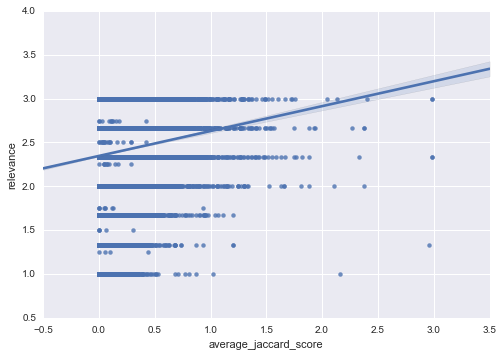

In [131]:
sns.regplot(x = 'average_jaccard_score', y = 'relevance', data=train);

** Analyze text to see if there is need for complicated tokenization, spelling correction etc. **

In [135]:
from nltk import FreqDist

In [142]:
train[['product_title', 'search_term', 'relevance']][:20]

product_title  \
0                   Simpson Strong-Tie 12-Gauge Angle   
1                   Simpson Strong-Tie 12-Gauge Angle   
2   BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3   Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4   Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
5   Whirlpool 1.9 cu. ft. Over the Range Convectio...   
6   Whirlpool 1.9 cu. ft. Over the Range Convectio...   
7   Whirlpool 1.9 cu. ft. Over the Range Convectio...   
8   Lithonia Lighting Quantum 2-Light Black LED Em...   
9   House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...   
10       Valley View Industries Metal Stakes (4-Pack)   
11  Toro Personal Pace Recycler 22 in. Variable Sp...   
12  Toro Personal Pace Recycler 22 in. Variable Sp...   
13  Toro Personal Pace Recycler 22 in. Variable Sp...   
14  Hampton Bay Caramel Simple Weave Bamboo Rollup...   
15  InSinkErator SinkTop Switch Single Outlet for ...   
16  Sunjoy Calais 8 ft. x 5 ft. x 8 ft. Steel Tile...   
17  MD Building Products 36 in. x 36 in. Cloverlea...   
18  MD Building Products 36 in. x 36 in. Cloverlea...   
19  MD Building Products 36 in. x 36 in. Cloverlea...   

                           search_term  relevance  
0                        angle bracket       3.00  
1                            l bracket       2.50  
2                            deck over       3.00  
3                     rain shower head       2.33  
4                   shower only faucet       2.67  
5                       convection otr       3.00  
6                 microwave over stove       2.67  
7                           microwaves       3.00  
8                      emergency light       2.67  
9                              mdf 3/4       3.00  
10                        steele stake       2.67  
11      briggs and stratton lawn mower       3.00  
12                            gas mowe       3.00  
13                         honda mower       2.00  
14  hampton bay chestnut pull up shade       2.67  
15                            disposer       2.67  
16                        grill gazebo       3.00  
17                         door guards       1.00  
18              metal plate cover gcfi       1.67  
19                      radiator grate       2.33

## Query Expansion

In [158]:
from collections import Counter

In [215]:
queries_ext_train = np.zeros(len(train)).astype(np.object)
queries = train.search_term
titles = train.product_title
y = train.relevance
data = []

for q in np.unique(train.search_term):
    q_mask = (queries == q).values
    
    titles_q = titles[q_mask]
    y_q = y[q_mask]
    
    good_mask = (y_q > 2.).values
    titles_good = titles_q[good_mask]
    
    ext_q = str(q)
    
    for item in titles_good:
        ext_q += ' ' + str(item)
    
    c = [word for word, it in Counter(ext_q.split()).most_common(10)]
    c = ' '.join(c)
    
    data.append([q, ext_q, c])
    queries_ext_train[q_mask] = c

## Feature Engineering

In [240]:
def num_words_in_query(query):
    return len(query.split())

def num_words_in_title(title):
    return len(title.split())

def query_title_overlap(row):
    query = row['search_term']
    title = row['product_title']
    query_words = query.split()
    
    count_overlap = 0
    for word in query_words:
        if query in title:
            count_overlap += 1
    
    return count_overlap

def levenshtein_distance(row):
    query = row['search_term']
    title = row['product_title']
    
    return 1 - seq_matcher(None, query, title).ratio()

In [241]:
train.loc[:, 'num_words_in_query'] = train.search_term.map(num_words_in_query)
train.loc[:, 'num_words_in_title'] = train.product_title.map(num_words_in_title)
train.loc[:, 'query_title_overlap'] = train.apply(query_title_overlap, axis=1)
train.loc[:, 'one-edit-distance'] = train.apply(levenshtein_distance, axis=1)

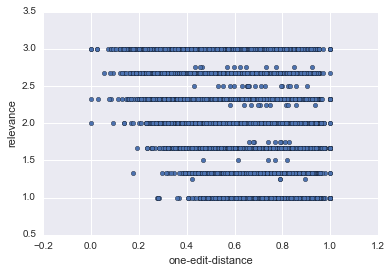

In [244]:
train.plot(kind='scatter', x = 'one-edit-distance', y = 'relevance');

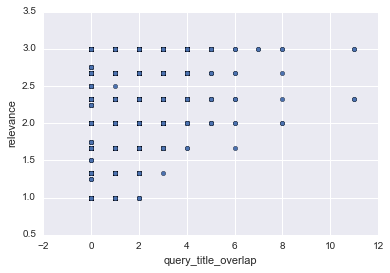

In [245]:
train.plot(kind='scatter', x = 'query_title_overlap', y = 'relevance');

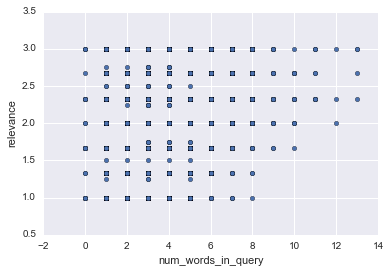

In [246]:
train.plot(kind='scatter', x = 'num_words_in_query', y = 'relevance');

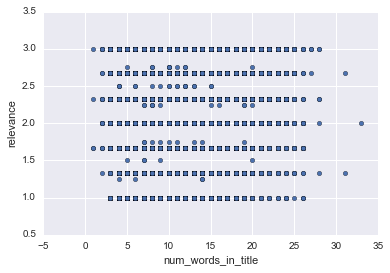

In [247]:
train.plot(kind='scatter', x = 'num_words_in_title', y = 'relevance');